In [2]:
# import libraries

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from IPython.display import display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

Data Exploration

In [3]:
# import dataset

dfm = pd.read_csv('MONTHLY_INCIDENTS_RAISED_2104.csv', encoding = "ISO-8859-1")
df = pd.read_csv('Data_Incidents_Raised.csv')

print("Dataframe contains " + format(dfm.shape[0]) + " sampels")
print("Dataframe contains " + format(df.shape[0]) + " sampels")

#display(dfm.head())
#display(df.head())

Dataframe contains 7790 sampels
Dataframe contains 30330 sampels


In [4]:
# drop meaningless columns

dfm.drop(['Incidenct Code','Customer Company','Incident Description','Support Group','Tower Group','Domain Group','Urgency','Resolution Description','Assigned Organization','Inc. Category','Last Modified Date','Inc. Element','Aging (Days)','Localización Cliente','Departamento Cliente'], axis=1, inplace=True)
df.drop(['Incidenct Code','Customer Company','Incident Description','Support Group','Tower Group','Domain Group','Urgency','Resolution Description','Assigned Organization','Inc. Category','Last Modified Date','Inc. Element','Aging (Days)','Localización Cliente','Departamento Cliente'], axis=1, inplace=True)

#display(dfm.head())
#display(df.head())

In [5]:
# drop IAG CARGO, IBERIA EXPRESS, OTHERS from Customer Company Group and drop the column

Meaningless_Values = len(dfm[dfm['Customer Company Group'] == "IAG CARGO"]) + len(dfm[dfm['Customer Company Group'] == "IBERIA EXPRESS"]) + len(dfm[dfm['Customer Company Group'] == "OTHERS"])
print(format(Meaningless_Values) + " rows containing IAG CARGO, IBERIA EXPRESS, and OTHERS are dropped")
Meaningless_Values = len(df[df['Customer Company Group'] == "IAG CARGO"]) + len(df[df['Customer Company Group'] == "IBERIA EXPRESS"]) + len(df[df['Customer Company Group'] == "OTHERS"])
print(format(Meaningless_Values) + " rows containing IAG CARGO, IBERIA EXPRESS, and OTHERS are dropped")

dfm.drop(dfm.index[dfm['Customer Company Group'] == 'IAG CARGO'], inplace=True)
dfm.drop(dfm.index[dfm['Customer Company Group'] == 'IBERIA EXPRESS'], inplace=True)
dfm.drop(dfm.index[dfm['Customer Company Group'] == 'OTHERS'], inplace=True)
df.drop(df.index[df['Customer Company Group'] == 'IAG CARGO'], inplace=True)
df.drop(df.index[df['Customer Company Group'] == 'IBERIA EXPRESS'], inplace=True)
df.drop(df.index[df['Customer Company Group'] == 'OTHERS'], inplace=True)

print("Remaining rows: " + format(dfm.shape[0]))
print("Remaining rows: " + format(df.shape[0]))

dfm.drop('Customer Company Group', axis=1, inplace=True)
df.drop('Customer Company Group', axis=1, inplace=True)

#display(dfm.head())
#display(df.head())

351 rows containing IAG CARGO, IBERIA EXPRESS, and OTHERS are dropped
1577 rows containing IAG CARGO, IBERIA EXPRESS, and OTHERS are dropped
Remaining rows: 7439
Remaining rows: 28753


In [6]:
# check features

target = 'Customer Company Group'

features = [i for i in dfm.columns if i not in [target]]
features = [i for i in df.columns if i not in [target]]

print('The Dataset consists of {} columns & {} samples.'.format(dfm.shape[1], dfm.shape[0]))
print('The Dataset consists of {} columns & {} samples.'.format(df.shape[1], df.shape[0]))

The Dataset consists of 5 columns & 7439 samples.
The Dataset consists of 5 columns & 28753 samples.


In [7]:
# check for empty elements

nvcm = pd.DataFrame(dfm.isnull().sum().sort_values(), columns=['Total Null Values'])
nvcm['Percentage'] = round(nvcm['Total Null Values']/dfm.shape[0],3)*100
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100

print(nvcm)
print(nvc)

#df.dropna(inplace=True)

                      Total Null Values  Percentage
Create Date-Time                      0         0.0
Priority                              0         0.0
Inc. Type                             0         0.0
Incident Status                     106         1.4
Resolution Date-Time                478         6.4
                      Total Null Values  Percentage
Create Date-Time                      0         0.0
Priority                              0         0.0
Inc. Type                             0         0.0
Incident Status                     363         1.3
Resolution Date-Time               1839         6.4


In [8]:
# check for unresolved incidents

unresolvedm = dfm['Resolution Date-Time'].isnull().sum()
unresolved = df['Resolution Date-Time'].isnull().sum()

print("Total of IBERIA's unresolved incidents: "+format(unresolvedm)+" out of "+format(dfm.shape[0])+" raised incidents ("+format(round(unresolvedm/dfm.shape[0],4)*100)+"% is unresolved).")
print("Total of IBERIA's unresolved incidents: "+format(unresolved)+" out of "+format(df.shape[0])+" raised incidents ("+format(round(unresolved/df.shape[0],4)*100)+"% is unresolved).")

Total of IBERIA's unresolved incidents: 478 out of 7439 raised incidents (6.43% is unresolved).
Total of IBERIA's unresolved incidents: 1839 out of 28753 raised incidents (6.4% is unresolved).


Feature Selection

In [9]:
# First, I'm going to reshape the 'Create Date-Time' and 'Resolution Date-Time' columns
# After this, I can use them to calculate the resolution time

dfm['Create Date-Time'] = pd.to_datetime(dfm['Create Date-Time'], dayfirst = True)
df['Create Date-Time'] = pd.to_datetime(df['Create Date-Time'], dayfirst = True)
dfm['Resolution Date-Time'] = pd.to_datetime(dfm['Resolution Date-Time'], dayfirst = True)
df['Resolution Date-Time'] = pd.to_datetime(df['Resolution Date-Time'], dayfirst = True)

dfm['time_to_resolve'] = dfm['Resolution Date-Time'] - dfm['Create Date-Time']
df['time_to_resolve'] = df['Resolution Date-Time'] - df['Create Date-Time']

#display(dfm.head(10))
#display(df.head(10))

In [10]:
# Add the SLA time according to the priority of each incident

## Create a new column 'SLA' with empty values
## iterate over the 'Priority' column, if the priority is "Baja" add "15 days 00:00:00" to 'SLA' 

dfm['SLA'] = dfm.apply(lambda _: '', axis=1)

for i in dfm.index:
    
    if dfm.Priority[i] == "Baja":
        dfm.at[i, 'SLA'] =  pd.Timedelta("15 days 00:00:00")
    elif dfm.Priority[i] == "Media":
        dfm.at[i, 'SLA'] =  pd.Timedelta("5 days 00:00:00")
    elif dfm.Priority[i] == "Alta":
        dfm.at[i, 'SLA'] =  pd.Timedelta("0 days 08:00:00")
    elif dfm.Priority[i] == "Crítica":
        dfm.at[i, 'SLA'] =  pd.Timedelta("0 days 04:00:00")


df['SLA'] = df.apply(lambda _: '', axis=1)

for i in df.index:
    
    if df.Priority[i] == "Baja":
        df.at[i, 'SLA'] =  pd.Timedelta("15 days 00:00:00")
    elif df.Priority[i] == "Media":
        df.at[i, 'SLA'] =  pd.Timedelta("5 days 00:00:00")
    elif df.Priority[i] == "Alta":
        df.at[i, 'SLA'] =  pd.Timedelta("0 days 08:00:00")
    elif df.Priority[i] == "Crítica":
        df.at[i, 'SLA'] =  pd.Timedelta("0 days 04:00:00")

#display(dfm.head(10))
#display(df.head(10))

In [11]:
# Check if Resolution time meets the SLA

dfm['meets SLA?'] = dfm.apply(lambda _: '', axis=1)

for i in dfm.index:
    
    if dfm.time_to_resolve[i] < dfm.SLA[i]:
        dfm.at[i, 'meets SLA?'] = "yes"
    elif dfm['Resolution Date-Time'].isnull()[i]:
        dfm.at[i, 'meets SLA?'] = "unresolved"
    else:
        dfm.at[i, 'meets SLA?'] = "no"

df['meets SLA?'] = df.apply(lambda _: '', axis=1)

for i in df.index:
    
    if df.time_to_resolve[i] < df.SLA[i]:
        df.at[i, 'meets SLA?'] = "yes"
    elif df['Resolution Date-Time'].isnull()[i]:
        df.at[i, 'meets SLA?'] = "unresolved"
    else:
        df.at[i, 'meets SLA?'] = "no"

In [12]:
df['Priority'] = df['Priority'].replace(['Baja'],'Low')
df['Priority'] = df['Priority'].replace(['Media'],'Medium')
df['Priority'] = df['Priority'].replace(['Alta'],'High')
df['Priority'] = df['Priority'].replace(['Crítica'],'Critical')

In [13]:
display(dfm.head(10))
display(dfm.tail(10))

display(df.head(10))
display(df.tail(10))

,Create Date-Time,Resolution Date-Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?
0,2021-04-01 00:17:00,2021-04-01 00:17:00,Closed,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
1,2021-04-01 00:05:00,2021-04-01 00:05:00,Closed,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
2,2021-04-01 00:42:00,2021-04-01 00:42:00,Closed,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
3,2021-04-01 00:36:00,2021-04-01 00:36:00,Closed,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
4,2021-04-01 00:38:00,2021-04-01 00:38:00,Closed,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
6,2021-04-01 04:04:00,2021-04-01 04:04:00,Closed,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
7,2021-04-01 04:31:00,2021-04-02 09:40:00,Closed,Media,SOFTWARE FAILURE,1 days 05:09:00,5 days 00:00:00,yes
8,2021-04-01 05:46:00,2021-04-01 12:13:00,Closed,Baja,SOFTWARE FAILURE,0 days 06:27:00,15 days 00:00:00,yes
9,2021-04-01 06:14:00,2021-04-01 07:32:00,Closed,Media,ACCESS FAILURE,0 days 01:18:00,5 days 00:00:00,yes
10,2021-04-01 08:27:00,2021-04-13 08:02:00,Closed,Media,HARDWARE FAILURE,11 days 23:35:00,5 days 00:00:00,no


,Create Date-Time,Resolution Date-Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?
7779,2021-04-30 20:35:00,NaT,Assigned,Media,PERFORMANCE ISSUE,NaT,5 days 00:00:00,unresolved
7780,2021-04-30 20:36:00,2021-04-30 20:36:00,Resolved,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
7781,2021-04-30 20:39:00,NaT,Assigned,Media,SOFTWARE FAILURE,NaT,5 days 00:00:00,unresolved
7782,2021-04-30 20:40:00,2021-04-30 20:40:00,Resolved,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
7784,2021-04-30 20:57:00,2021-04-30 23:27:00,Resolved,Media,PERFORMANCE ISSUE,0 days 02:30:00,5 days 00:00:00,yes
7785,2021-04-30 21:32:00,2021-04-30 21:32:00,Resolved,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
7786,2021-04-30 22:05:00,NaT,Assigned,Baja,PROCESS FAILURE,NaT,15 days 00:00:00,unresolved
7787,2021-04-30 23:52:00,2021-04-30 23:52:00,Resolved,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
7788,2021-04-30 22:33:00,2021-04-30 23:25:00,Resolved,Media,PERFORMANCE ISSUE,0 days 00:52:00,5 days 00:00:00,yes
7789,2021-04-30 22:45:00,2021-04-30 22:45:00,Resolved,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes


,Create Date-Time,Resolution Date-Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?
1,2021-01-01 03:11:00,2021-01-01 10:00:00,Closed,Medium,PERFORMANCE ISSUE,0 days 06:49:00,5 days 00:00:00,yes
2,2021-01-01 04:10:00,2021-01-04 11:00:00,Closed,Medium,PERFORMANCE ISSUE,3 days 06:50:00,5 days 00:00:00,yes
3,2021-01-01 04:51:00,2021-01-11 17:23:00,Closed,Low,SOFTWARE FAILURE,10 days 12:32:00,15 days 00:00:00,yes
4,2021-01-01 04:58:00,2021-01-03 03:55:00,Closed,Medium,PERFORMANCE ISSUE,1 days 22:57:00,5 days 00:00:00,yes
5,2021-01-01 06:46:00,2021-01-02 14:58:00,Closed,Medium,PERFORMANCE ISSUE,1 days 08:12:00,5 days 00:00:00,yes
6,2021-01-01 08:30:00,2021-01-01 20:45:00,Closed,High,DEFAULT,0 days 12:15:00,0 days 08:00:00,no
7,2021-01-01 08:46:00,2021-01-01 13:24:00,Closed,Medium,SOFTWARE FAILURE,0 days 04:38:00,5 days 00:00:00,yes
9,2021-01-01 08:55:00,2021-01-01 11:20:00,Closed,Low,SOFTWARE FAILURE,0 days 02:25:00,15 days 00:00:00,yes
10,2021-01-01 09:05:00,2021-01-04 06:42:00,Closed,Medium,PROCESS FAILURE,2 days 21:37:00,5 days 00:00:00,yes
11,2021-01-01 09:00:00,2021-01-01 11:23:00,Closed,Low,SOFTWARE FAILURE,0 days 02:23:00,15 days 00:00:00,yes


,Create Date-Time,Resolution Date-Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?
30319,2021-04-30 20:35:00,NaT,Assigned,Medium,PERFORMANCE ISSUE,NaT,5 days 00:00:00,unresolved
30320,2021-04-30 20:36:00,2021-04-30 20:36:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30321,2021-04-30 20:39:00,NaT,Assigned,Medium,SOFTWARE FAILURE,NaT,5 days 00:00:00,unresolved
30322,2021-04-30 20:40:00,2021-04-30 20:40:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30324,2021-04-30 20:57:00,2021-04-30 23:27:00,Resolved,Medium,PERFORMANCE ISSUE,0 days 02:30:00,5 days 00:00:00,yes
30325,2021-04-30 21:32:00,2021-04-30 21:32:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30326,2021-04-30 22:05:00,NaT,Assigned,Low,PROCESS FAILURE,NaT,15 days 00:00:00,unresolved
30327,2021-04-30 23:52:00,2021-04-30 23:52:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30328,2021-04-30 22:33:00,2021-04-30 23:25:00,Resolved,Medium,PERFORMANCE ISSUE,0 days 00:52:00,5 days 00:00:00,yes
30329,2021-04-30 22:45:00,2021-04-30 22:45:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes


KPI Calculations/Data Insights

In [14]:
dfm1 = dfm.copy()
df1 = df.copy()

In [15]:
## Check number of incidents per priority      TABLE

#df['Priority'].value_counts().Crítica
display(dfm1['Priority'].value_counts())

## Total number of incidents raised in a month      TABLE

dfm2 = dfm.copy()

dfm2['Create Date-Time'] = dfm2['Create Date-Time'].dt.strftime('%Y-%m')
display(dfm2['Create Date-Time'].value_counts())

Baja       5281
Media      2038
Alta        115
Crítica       5
Name: Priority, dtype: int64

2021-04    7439
Name: Create Date-Time, dtype: int64

In [16]:
size=dfm2.groupby(['Create Date-Time','Priority'], sort = False).size().reset_index().rename(columns={0:'Incidents'})
dfm2.groupby(['Create Date-Time','Priority'], sort = False)['time_to_resolve'].mean().reset_index()

,Create Date-Time,Priority,time_to_resolve
0,2021-04,Baja,0 days 15:55:38.443610507
1,2021-04,Media,1 days 18:52:07.318718381
2,2021-04,Alta,0 days 15:15:13.684210526
3,2021-04,Crítica,0 days 02:10:00


In [17]:
## Check number of incidents per priority      TABLE

#df['Priority'].value_counts().Crítica
display(df1['Priority'].value_counts())

## Total number of incidents raised in a month      TABLE

df2 = df.copy()

df2['Create Date-Time'] = df2['Create Date-Time'].dt.strftime('%Y-%m')
display(df2['Create Date-Time'].value_counts())

display(df2)

df2.shape[0]

Low         19905
Medium       8331
High          499
Critical       18
Name: Priority, dtype: int64

2021-01    7606
2021-03    7449
2021-04    7439
2021-02    6259
Name: Create Date-Time, dtype: int64

,Create Date-Time,Resolution Date-Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?
1,2021-01,2021-01-01 10:00:00,Closed,Medium,PERFORMANCE ISSUE,0 days 06:49:00,5 days 00:00:00,yes
2,2021-01,2021-01-04 11:00:00,Closed,Medium,PERFORMANCE ISSUE,3 days 06:50:00,5 days 00:00:00,yes
3,2021-01,2021-01-11 17:23:00,Closed,Low,SOFTWARE FAILURE,10 days 12:32:00,15 days 00:00:00,yes
4,2021-01,2021-01-03 03:55:00,Closed,Medium,PERFORMANCE ISSUE,1 days 22:57:00,5 days 00:00:00,yes
5,2021-01,2021-01-02 14:58:00,Closed,Medium,PERFORMANCE ISSUE,1 days 08:12:00,5 days 00:00:00,yes
...,...,...,...,...,...,...,...,...
30325,2021-04,2021-04-30 21:32:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30326,2021-04,NaT,Assigned,Low,PROCESS FAILURE,NaT,15 days 00:00:00,unresolved
30327,2021-04,2021-04-30 23:52:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30328,2021-04,2021-04-30 23:25:00,Resolved,Medium,PERFORMANCE ISSUE,0 days 00:52:00,5 days 00:00:00,yes


28753

In [85]:
dfn = df2.groupby(['Create Date-Time'], sort = False).size().reset_index().rename(columns={0:'Incidents'})
dfn

,Create Date-Time,Incidents
0,2021-01,7606
1,2021-02,6259
2,2021-03,7449
3,2021-04,7439


In [90]:
dfn = df2.groupby(['Create Date-Time'], sort = False).size().reset_index().rename(columns={0:'Incidents'})
dfn.rename(columns={'Create Date-Time': 'Month'}, inplace = True)
dfn['Month'] = dfn['Month'].replace(['2021-01'],'January')
dfn['Month'] = dfn['Month'].replace(['2021-02'],'February')
dfn['Month'] = dfn['Month'].replace(['2021-03'],'March')
dfn['Month'] = dfn['Month'].replace(['2021-04'],'April')
dfn

,Month,Incidents
0,January,7606
1,February,6259
2,March,7449
3,April,7439


In [18]:
df4 = pd.get_dummies(df2, columns = ['meets SLA?'])
df4

,Create Date-Time,Resolution Date-Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?_no,meets SLA?_unresolved,meets SLA?_yes
1,2021-01,2021-01-01 10:00:00,Closed,Medium,PERFORMANCE ISSUE,0 days 06:49:00,5 days 00:00:00,0,0,1
2,2021-01,2021-01-04 11:00:00,Closed,Medium,PERFORMANCE ISSUE,3 days 06:50:00,5 days 00:00:00,0,0,1
3,2021-01,2021-01-11 17:23:00,Closed,Low,SOFTWARE FAILURE,10 days 12:32:00,15 days 00:00:00,0,0,1
4,2021-01,2021-01-03 03:55:00,Closed,Medium,PERFORMANCE ISSUE,1 days 22:57:00,5 days 00:00:00,0,0,1
5,2021-01,2021-01-02 14:58:00,Closed,Medium,PERFORMANCE ISSUE,1 days 08:12:00,5 days 00:00:00,0,0,1
...,...,...,...,...,...,...,...,...,...,...
30325,2021-04,2021-04-30 21:32:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,0,0,1
30326,2021-04,NaT,Assigned,Low,PROCESS FAILURE,NaT,15 days 00:00:00,0,1,0
30327,2021-04,2021-04-30 23:52:00,Resolved,Low,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,0,0,1
30328,2021-04,2021-04-30 23:25:00,Resolved,Medium,PERFORMANCE ISSUE,0 days 00:52:00,5 days 00:00:00,0,0,1


In [19]:
df4[(df4['Create Date-Time'] == '2021-04') & (df2['Priority'] == 'Critical')]['meets SLA?_yes'].sum()

5

In [20]:
df2.groupby(['Create Date-Time','Priority'], sort = False).size().reset_index().rename(columns={0:'Incidents'})
df2.groupby(['Create Date-Time','Priority'], sort = False)['time_to_resolve'].mean().reset_index().rename(columns={0:'Incidents'})


,Create Date-Time,Priority,time_to_resolve
0,2021-01,Medium,1 days 16:21:16.206185567
1,2021-01,Low,0 days 17:58:42.525985487
2,2021-01,High,0 days 03:36:16.535433070
3,2021-01,Critical,0 days 05:10:00
4,2021-02,Low,0 days 21:27:22.618272841
5,2021-02,Medium,1 days 18:45:43.505275498
6,2021-02,High,0 days 06:04:25.081967213
7,2021-02,Critical,0 days 04:53:20
8,2021-03,Low,0 days 17:53:35.674019607
9,2021-03,Medium,1 days 21:26:23.187500


In [21]:
df2.groupby(['Priority','Create Date-Time','meets SLA?'], sort = True).size().reset_index().rename(columns={0:'Incidents'})

,Priority,Create Date-Time,meets SLA?,Incidents
0,Critical,2021-01,no,2
1,Critical,2021-01,yes,2
2,Critical,2021-02,no,1
3,Critical,2021-02,yes,2
4,Critical,2021-03,no,4
5,Critical,2021-03,yes,2
6,Critical,2021-04,yes,5
7,High,2021-01,no,9
8,High,2021-01,yes,118
9,High,2021-02,no,17


In [22]:
df2_dummies = pd.get_dummies(df2, prefix = ['Month'], columns = ['Create Date-Time'])
df2_dummies.head()

,Resolution Date-Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?,Month_2021-01,Month_2021-02,Month_2021-03,Month_2021-04
1,2021-01-01 10:00:00,Closed,Medium,PERFORMANCE ISSUE,0 days 06:49:00,5 days 00:00:00,yes,1,0,0,0
2,2021-01-04 11:00:00,Closed,Medium,PERFORMANCE ISSUE,3 days 06:50:00,5 days 00:00:00,yes,1,0,0,0
3,2021-01-11 17:23:00,Closed,Low,SOFTWARE FAILURE,10 days 12:32:00,15 days 00:00:00,yes,1,0,0,0
4,2021-01-03 03:55:00,Closed,Medium,PERFORMANCE ISSUE,1 days 22:57:00,5 days 00:00:00,yes,1,0,0,0
5,2021-01-02 14:58:00,Closed,Medium,PERFORMANCE ISSUE,1 days 08:12:00,5 days 00:00:00,yes,1,0,0,0


In [23]:
## Number of incidences raised per priority in the month        BAR CHART

display(dfm2.groupby(dfm2['Create Date-Time'])['Priority'].value_counts())


Create Date-Time  Priority
2021-04           Baja        5281
                  Media       2038
                  Alta         115
                  Crítica        5
Name: Priority, dtype: int64

In [24]:
df4 = pd.get_dummies(df2, columns = ['Create Date-Time', 'Priority'])
df4

,Resolution Date-Time,Incident Status,Inc. Type,time_to_resolve,SLA,meets SLA?,Create Date-Time_2021-01,Create Date-Time_2021-02,Create Date-Time_2021-03,Create Date-Time_2021-04,Priority_Critical,Priority_High,Priority_Low,Priority_Medium
1,2021-01-01 10:00:00,Closed,PERFORMANCE ISSUE,0 days 06:49:00,5 days 00:00:00,yes,1,0,0,0,0,0,0,1
2,2021-01-04 11:00:00,Closed,PERFORMANCE ISSUE,3 days 06:50:00,5 days 00:00:00,yes,1,0,0,0,0,0,0,1
3,2021-01-11 17:23:00,Closed,SOFTWARE FAILURE,10 days 12:32:00,15 days 00:00:00,yes,1,0,0,0,0,0,1,0
4,2021-01-03 03:55:00,Closed,PERFORMANCE ISSUE,1 days 22:57:00,5 days 00:00:00,yes,1,0,0,0,0,0,0,1
5,2021-01-02 14:58:00,Closed,PERFORMANCE ISSUE,1 days 08:12:00,5 days 00:00:00,yes,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30325,2021-04-30 21:32:00,Resolved,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes,0,0,0,1,0,0,1,0
30326,NaT,Assigned,PROCESS FAILURE,NaT,15 days 00:00:00,unresolved,0,0,0,1,0,0,1,0
30327,2021-04-30 23:52:00,Resolved,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes,0,0,0,1,0,0,1,0
30328,2021-04-30 23:25:00,Resolved,PERFORMANCE ISSUE,0 days 00:52:00,5 days 00:00:00,yes,0,0,0,1,0,0,0,1


In [25]:
## Number of incidences raised per priority in the month        BAR CHART

df2.groupby(df2['Create Date-Time'])['Priority'].value_counts()

Create Date-Time  Priority
2021-01           Low         5316
                  Medium      2159
                  High         127
                  Critical       4
2021-02           Low         4201
                  Medium      1933
                  High         122
                  Critical       3
2021-03           Low         5107
                  Medium      2201
                  High         135
                  Critical       6
2021-04           Low         5281
                  Medium      2038
                  High         115
                  Critical       5
Name: Priority, dtype: int64

In [26]:
## Number of incidences per cause       TABLE/HISTOGRAM

df2['Inc. Type'].value_counts()   

ACCESS FAILURE                                                 15115
SOFTWARE FAILURE                                                6725
PERFORMANCE ISSUE                                               3094
DATA ISSUE                                                       864
PROCESS FAILURE                                                  774
DEFAULT                                                          633
COMMUNICATIONS FAILURE                                           451
HARDWARE FAILURE                                                 382
TELEPHONY FAILURE                                                221
PRINTING FAILURE                                                 195
SECURITY ISSUE.CYBERATTACKS                                      102
SOFTWARE WARNING                                                 101
SECURITY ISSUE                                                    89
HARDWARE WARNING                                                   4
SECURITY ISSUE.PHYSICAL AND ENVIRO

In [63]:
ct = df2.groupby(['Create Date-Time','Inc. Type'], sort = False).size().reset_index().rename(columns={0:'Incidents'})
ct
tr = df2.groupby(['Create Date-Time','Inc. Type'], sort = False)['time_to_resolve'].mean().reset_index()
tr
ct['Avg. Resolution time'] = tr['time_to_resolve']
ct

,Create Date-Time,Inc. Type,Incidents,Avg. Resolution time
0,2021-01,PERFORMANCE ISSUE,768,1 days 01:08:02.579750346
1,2021-01,SOFTWARE FAILURE,1764,2 days 07:06:44.007936507
2,2021-01,DEFAULT,126,2 days 04:09:16
3,2021-01,PROCESS FAILURE,208,2 days 10:22:59.682539682
4,2021-01,ACCESS FAILURE,4192,0 days 05:51:16.351807228
5,2021-01,TELEPHONY FAILURE,57,2 days 19:21:55
6,2021-01,COMMUNICATIONS FAILURE,96,1 days 09:31:36.521739130
7,2021-01,DATA ISSUE,211,3 days 02:11:21.758241758
8,2021-01,HARDWARE FAILURE,83,2 days 23:44:53.333333333
9,2021-01,PRINTING FAILURE,44,2 days 06:19:07.692307692


In [67]:
cat = dfm2.groupby(['Create Date-Time','Inc. Type'], sort = False).size().reset_index().rename(columns={0:'Incidents'})
cat
ttr = dfm2.groupby(['Create Date-Time','Inc. Type'], sort = False)['time_to_resolve'].mean().reset_index()
ttr
# ttr['time_to_resolve'] = 
for i in ttr.index:
    ttr['time_to_resolve'][i] = pd.Timedelta(ttr['time_to_resolve'][i]).round(freq = 's')
ttr['time_to_resolve']

C:\Users\Jules\AppData\Local\Temp/ipykernel_6952/1041669419.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttr['time_to_resolve'][i] = pd.Timedelta(ttr['time_to_resolve'][i]).round(freq = 's')


0    0 days 03:07:33
1    2 days 13:47:50
2    1 days 16:19:47
3    2 days 23:11:02
4    2 days 14:19:46
5    0 days 22:18:44
6    2 days 18:05:51
7    5 days 21:27:51
8    1 days 23:00:16
9    2 days 12:11:54
10   1 days 04:52:27
11   0 days 12:42:48
12   0 days 13:29:38
Name: time_to_resolve, dtype: timedelta64[ns]

In [68]:
cat['Avg. Resolution time'] = ttr['time_to_resolve']
cat.sort_values(by='Incidents', ascending=False)

,Create Date-Time,Inc. Type,Incidents,Avg. Resolution time
0,2021-04,ACCESS FAILURE,4100,0 days 03:07:33
1,2021-04,SOFTWARE FAILURE,1553,2 days 13:47:50
5,2021-04,PERFORMANCE ISSUE,705,0 days 22:18:44
9,2021-04,DATA ISSUE,225,2 days 12:11:54
3,2021-04,PROCESS FAILURE,211,2 days 23:11:02
8,2021-04,DEFAULT,211,1 days 23:00:16
2,2021-04,HARDWARE FAILURE,128,1 days 16:19:47
10,2021-04,COMMUNICATIONS FAILURE,126,1 days 04:52:27
6,2021-04,TELEPHONY FAILURE,72,2 days 18:05:51
4,2021-04,PRINTING FAILURE,49,2 days 14:19:46


In [79]:
cat['Avg. Resolution time'].astype(str)
cat.dtypes

Create Date-Time        object
Inc. Type               object
Incidents                int64
Avg. Resolution time    object
dtype: object

In [127]:
## Number of incidences P1 in the month meeting SLA resolution time
## Number of incidences P1 in the month not meeting SLA resolution time
## Number of incidences meeting SLA per priority

#df2.groupby(['Priority'])['meets SLA?'].value_counts()   
dfm2.groupby(['Create Date-Time','Priority'], sort = False)['meets SLA?'].value_counts()

Create Date-Time  Priority  meets SLA?
2021-04           Baja      yes           5053
                            unresolved     218
                            no              10
                  Media     yes           1598
                            unresolved     259
                            no             181
                  Alta      yes             88
                            no              26
                            unresolved       1
                  Crítica   yes              5
Name: meets SLA?, dtype: int64

In [140]:
## Number of incidences P1 in the month meeting SLA resolution time
## Number of incidences P1 in the month not meeting SLA resolution time
## Number of incidences meeting SLA per priority

#df2.groupby(['Priority'])['meets SLA?'].value_counts()   
df2.groupby(['Create Date-Time','Priority'], sort = False)['meets SLA?'].value_counts(sort=True)

Create Date-Time  Priority  meets SLA?
2021-01           Media     yes           1760
                            unresolved     219
                            no             180
                  Baja      yes           5075
                            unresolved     217
                            no              24
                  Alta      yes            118
                            no               9
                  Crítica   no               2
                            yes              2
2021-02           Baja      yes           3983
                            unresolved     206
                            no              12
                  Media     yes           1534
                            unresolved     227
                            no             172
                  Alta      yes            105
                            no              17
                  Crítica   yes              2
                            no               1
2021-03           Baj

In [128]:
## % of incidences P1 meeting SLA               PIE CHART per Priority
## % of incidences P1 not meeting SLA

dfm2.groupby(['Priority'], sort = False)['meets SLA?'].value_counts("%")
#len(df2[df2['Priority'] == "Crítica"])

Priority  meets SLA?
Baja      yes           0.956826
          unresolved    0.041280
          no            0.001894
Media     yes           0.784102
          unresolved    0.127085
          no            0.088813
Alta      yes           0.765217
          no            0.226087
          unresolved    0.008696
Crítica   yes           1.000000
Name: meets SLA?, dtype: float64

In [112]:
## % of incidences P1 meeting SLA               PIE CHART per Priority
## % of incidences P1 not meeting SLA

df2.groupby(['Priority'], sort = False)['meets SLA?'].value_counts("%")
#len(df2[df2['Priority'] == "Crítica"])

Priority  meets SLA?
Media     yes           0.790661
          unresolved    0.118353
          no            0.090985
Baja      yes           0.953981
          unresolved    0.042803
          no            0.003215
Alta      yes           0.843687
          no            0.154309
          unresolved    0.002004
Crítica   yes           0.611111
          no            0.388889
Name: meets SLA?, dtype: float64

In [120]:
df2.Priority.value_counts()
df2.Priority
len(df[df['Priority'] == "Crítica"])


18

In [135]:
dfm2.groupby(['Create Date-Time','Priority'], sort = False).size().reset_index().rename(columns={0:'Incidents'})

,Create Date-Time,Priority,Incidents
0,2021-04,Baja,5281
1,2021-04,Media,2038
2,2021-04,Alta,115
3,2021-04,Crítica,5


In [134]:
df2.groupby(['Priority'], sort = False).size().reset_index().rename(columns={0:'Incidents'})

,Priority,Incidents
0,Media,8331
1,Baja,19905
2,Alta,499
3,Crítica,18


In [ ]:
##########################

In [132]:
## Average resolution time for incidences P1 meeting SLA            BAR CHART
## Average resolution time for incidences P1 not meeting SLA

dfm2.groupby(['Priority','meets SLA?'])['time_to_resolve'].mean()

Priority  meets SLA?
Alta      no           2 days 12:44:55.384615384
          unresolved                         NaT
          yes          0 days 01:48:43.636363636
Baja      no                    20 days 02:54:48
          unresolved                         NaT
          yes          0 days 15:00:11.411042944
Crítica   yes                    0 days 02:10:00
Media     no           8 days 19:55:29.171270718
          unresolved                         NaT
          yes          0 days 23:43:13.066332916
Name: time_to_resolve, dtype: timedelta64[ns]

In [108]:
## Average resolution time for incidences P1 meeting SLA            BAR CHART
## Average resolution time for incidences P1 not meeting SLA

df2.groupby(['Priority','meets SLA?'])['time_to_resolve'].mean()

Priority  meets SLA?
Alta      no           1 days 14:42:17.142857142
          unresolved                         NaT
          yes          0 days 02:03:41.187648456
Baja      no             18 days 10:21:07.500000
          unresolved                         NaT
          yes          0 days 16:42:39.575543735
Crítica   no           0 days 19:47:42.857142857
          yes          0 days 02:05:32.727272727
Media     no           8 days 22:15:22.401055409
          unresolved                         NaT
          yes          0 days 23:07:39.313799908
Name: time_to_resolve, dtype: timedelta64[ns]

In [52]:
## Number of Unresolved Incidents           PIE CHART

unresolved = df2['Resolution Date-Time'].isnull().sum()

print("Total of IBERIA's unresolved incidents: "+format(unresolved)+" out of "+format(df.shape[0])+" raised incidents ("+format(round(unresolved/df.shape[0],4)*100)+"% is unresolved).")

Total of IBERIA's unresolved incidents: 1839 out of 28753 raised incidents (6.4% is unresolved).


In [58]:
## Type of incident that on average takes the most time to resolve  BAR CHART <<<<<<<<<<<<<<<<<<<<<

df2.groupby(['Inc. Type'], sort = False)['time_to_resolve'].mean()

Inc. Type
PERFORMANCE ISSUE                                             0 days 22:42:12.012278308
SOFTWARE FAILURE                                              2 days 14:06:27.931034482
DEFAULT                                                       2 days 01:04:06.020761245
PROCESS FAILURE                                               2 days 14:43:24.686192468
ACCESS FAILURE                                                0 days 04:19:35.261995583
TELEPHONY FAILURE                                             2 days 21:57:13.507853403
COMMUNICATIONS FAILURE                                        1 days 07:26:48.142857142
DATA ISSUE                                                    2 days 18:55:56.824966078
HARDWARE FAILURE                                              2 days 00:32:42.958579881
PRINTING FAILURE                                              2 days 04:42:35.849056603
SECURITY ISSUE                                                3 days 11:55:37.297297297
SECURITY ISSUE.CYBERAT

In [60]:
df2.groupby(['Priority'], sort = False)['Inc. Type'].value_counts()

Priority  Inc. Type                                                  
Media     SOFTWARE FAILURE                                                3354
          PERFORMANCE ISSUE                                               2188
          ACCESS FAILURE                                                  1347
          DEFAULT                                                          315
          DATA ISSUE                                                       295
          COMMUNICATIONS FAILURE                                           283
          PROCESS FAILURE                                                  152
          HARDWARE FAILURE                                                 112
          SECURITY ISSUE                                                    86
          TELEPHONY FAILURE                                                 67
          PRINTING FAILURE                                                  66
          SOFTWARE WARNING                                   

In [ ]:
## Show Current Unresolved P1 Incidents

Data Visualisation

In [ ]:
#df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset',color="white")
plt.pie([df.shape[0], unresolved], radius = 1, labels=['Resolved','Unresolved'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

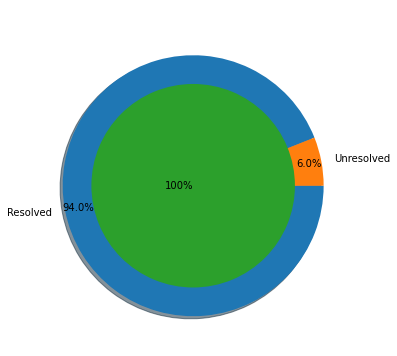

In [22]:
#df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset',color="white")
plt.pie([df.shape[0], unresolved], radius = 1, labels=['Resolved','Unresolved'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

In [23]:
nu = df.drop(["Priority"], axis=1).nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df.drop(["Priority"], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

C:\Users\Jules\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jules\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jules\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: num must be 1 <= num <= 3, not 0

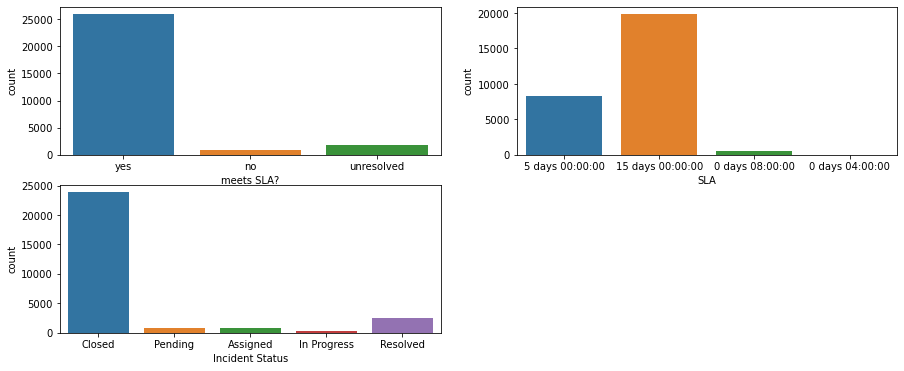

In [24]:
n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

# for i in range(len(cf)):
#     if df[cf[i]].nunique()<=4:
#         plt.subplot(math.ceil(len(cf)/n),n,i+1)
#         sns.countplot(df[cf[i]])
#     else:
#         plt.subplot(math.ceil(len(cf)/2),2,i)
#         sns.countplot(df[cf[i]])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])
        #plt.subplot(4,2,8)
        #sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

In [ ]:
df

,Create Date_Time,Resolution Date_Time,Incident Status,Priority,Inc. Type,time_to_resolve,SLA,meets SLA?
1,2021-01-01 03:11:00,2021-01-01 10:00:00,Closed,Media,PERFORMANCE ISSUE,0 days 06:49:00,5 days 00:00:00,yes
2,2021-01-01 04:10:00,2021-01-04 11:00:00,Closed,Media,PERFORMANCE ISSUE,3 days 06:50:00,5 days 00:00:00,yes
3,2021-01-01 04:51:00,2021-01-11 17:23:00,Closed,Baja,SOFTWARE FAILURE,10 days 12:32:00,15 days 00:00:00,yes
4,2021-01-01 04:58:00,2021-01-03 03:55:00,Closed,Media,PERFORMANCE ISSUE,1 days 22:57:00,5 days 00:00:00,yes
5,2021-01-01 06:46:00,2021-01-02 14:58:00,Closed,Media,PERFORMANCE ISSUE,1 days 08:12:00,5 days 00:00:00,yes
...,...,...,...,...,...,...,...,...
30325,2021-04-30 21:32:00,2021-04-30 21:32:00,Resolved,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30326,2021-04-30 22:05:00,NaT,Assigned,Baja,PROCESS FAILURE,NaT,15 days 00:00:00,unresolved
30327,2021-04-30 23:52:00,2021-04-30 23:52:00,Resolved,Baja,ACCESS FAILURE,0 days 00:00:00,15 days 00:00:00,yes
30328,2021-04-30 22:33:00,2021-04-30 23:25:00,Resolved,Media,PERFORMANCE ISSUE,0 days 00:52:00,5 days 00:00:00,yes
